- Binary classification (Positive and Negative)
- Model used: Logistic Regression & Support Vector Machine (SVM)
- Dataset: IMBD Dataset (As of now)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk import tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from collections import Counter
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

sns.set_style(style = 'darkgrid')

# Data Extraction

In [2]:
review_df = pd.read_csv('IMDB Dataset.csv')

In [3]:
review_df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [4]:
review_df.shape

(50000, 2)

We are going to use 10000 rows (50000 is too much as of now)

In [5]:
review_df = review_df.sample(frac = 0.1, random_state = 42)
review_df = review_df.reset_index(drop = True)

In [6]:
review_df.shape

(5000, 2)

In [7]:
review_df.dtypes

review       object
sentiment    object
dtype: object

In [8]:
# map sentiment strings to integers: positive -> 1, negative -> 0
review_df['sentiment'] = review_df['sentiment'].map({'positive': 1, 'negative': 0}).astype(int)

In [9]:
review_df['sentiment'].value_counts()

sentiment
1    2519
0    2481
Name: count, dtype: int64

# Exploratory Data Analysis

In [10]:
length = len(review_df['review'][0]) # Check length for the first review
print(f"Length of a sample review: {length}")

Length of a sample review: 1107


In [11]:
review_df['Length'] = review_df['review'].str.len()
review_df.head(10)

,review,sentiment,Length
0,I really liked this Summerslam due to the look...,1,1107
1,Not many television shows appeal to quite as m...,1,2054
2,The film quickly gets to a major chase scene w...,0,653
3,Jane Austen would definitely approve of this o...,1,632
4,Expectations were somewhat high for me when I ...,0,1900
5,I've watched this movie on a fairly regular ba...,1,3193
6,For once a story of hope highlighted over the ...,1,655
7,"Okay, I didn't get the Purgatory thing the fir...",1,2519
8,I was very disappointed with this series. It h...,0,1875
9,The first 30 minutes of Tinseltown had my fing...,0,1858


Word count: Number of words in a review

In [12]:
word_count = review_df['review'][0].split() # Check word count for the first review
print(f"Word count in a sample review: {len(word_count)}")

Word count in a sample review: 201


In [13]:
def word_count(review_df):
    review_list = review_df.split()
    return len(review_list)

In [14]:
review_df['Word_count'] = review_df['review'].apply(word_count)
review_df.head(10)

,review,sentiment,Length,Word_count
0,I really liked this Summerslam due to the look...,1,1107,201
1,Not many television shows appeal to quite as m...,1,2054,354
2,The film quickly gets to a major chase scene w...,0,653,119
3,Jane Austen would definitely approve of this o...,1,632,99
4,Expectations were somewhat high for me when I ...,0,1900,332
5,I've watched this movie on a fairly regular ba...,1,3193,571
6,For once a story of hope highlighted over the ...,1,655,110
7,"Okay, I didn't get the Purgatory thing the fir...",1,2519,437
8,I was very disappointed with this series. It h...,0,1875,322
9,The first 30 minutes of Tinseltown had my fing...,0,1858,315


Mean word length: Average length of words

In [15]:
review_df['mean_word_length'] = review_df['review'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
review_df.head(10)

,review,sentiment,Length,Word_count,mean_word_length
0,I really liked this Summerslam due to the look...,1,1107,201,4.512438
1,Not many television shows appeal to quite as m...,1,2054,354,4.805085
2,The film quickly gets to a major chase scene w...,0,653,119,4.495798
3,Jane Austen would definitely approve of this o...,1,632,99,5.393939
4,Expectations were somewhat high for me when I ...,0,1900,332,4.725904
5,I've watched this movie on a fairly regular ba...,1,3193,571,4.593695
6,For once a story of hope highlighted over the ...,1,655,110,4.963636
7,"Okay, I didn't get the Purgatory thing the fir...",1,2519,437,4.766590
8,I was very disappointed with this series. It h...,0,1875,322,4.826087
9,The first 30 minutes of Tinseltown had my fing...,0,1858,315,4.901587


Mean sentence length: Average length of the sentences in the review

In [16]:
np.mean([len(sent) for sent in tokenize.sent_tokenize(review_df['review'][0])])

np.float64(220.6)

In [17]:
review_df['mean_sentence_length'] = review_df['review'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))
review_df.head(10)

,review,sentiment,Length,Word_count,mean_word_length,mean_sentence_length
0,I really liked this Summerslam due to the look...,1,1107,201,4.512438,220.600000
1,Not many television shows appeal to quite as m...,1,2054,354,4.805085,255.875000
2,The film quickly gets to a major chase scene w...,0,653,119,4.495798,217.000000
3,Jane Austen would definitely approve of this o...,1,632,99,5.393939,125.600000
4,Expectations were somewhat high for me when I ...,0,1900,332,4.725904,125.733333
5,I've watched this movie on a fairly regular ba...,1,3193,571,4.593695,109.137931
6,For once a story of hope highlighted over the ...,1,655,110,4.963636,130.200000
7,"Okay, I didn't get the Purgatory thing the fir...",1,2519,437,4.766590,99.800000
8,I was very disappointed with this series. It h...,0,1875,322,4.826087,109.411765
9,The first 30 minutes of Tinseltown had my fing...,0,1858,315,4.901587,264.571429


## Term Frequency Analysis
- Term frequency measures how often a specific word appears in a document, indicating its importance within that text.

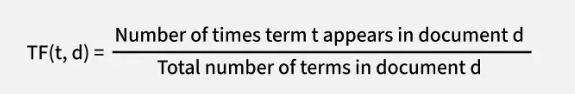

In [18]:
review_df = review_df.drop(['Length', 'Word_count', 'mean_word_length', 'mean_sentence_length'], axis = 1)

In [19]:
review_df.head()

,review,sentiment
0,I really liked this Summerslam due to the look...,1
1,Not many television shows appeal to quite as m...,1
2,The film quickly gets to a major chase scene w...,0
3,Jane Austen would definitely approve of this o...,1
4,Expectations were somewhat high for me when I ...,0


In [20]:
review_df.isnull().sum()

review       0
sentiment    0
dtype: int64

For Term Frequency Analysis, the following needs text data needs to be processed:
- Lowercase
- Remove punctuation
- Stopword removal

In [24]:
def clean(review_df):
    review = review_df.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review_df.split() if word not in stopwords.words('english')])
    review = review_df.replace('<br /><br />', ' ') # Replace HTML linebreak format with empty space
    
    return review

In [25]:
review_df['review'] = review_df['review'].apply(clean)
review_df.head(10)

,review,sentiment
0,I really liked this Summerslam due to the look...,1
1,Not many television shows appeal to quite as m...,1
2,The film quickly gets to a major chase scene w...,0
3,Jane Austen would definitely approve of this o...,1
4,Expectations were somewhat high for me when I ...,0
5,I've watched this movie on a fairly regular ba...,1
6,For once a story of hope highlighted over the ...,1
7,"Okay, I didn't get the Purgatory thing the fir...",1
8,I was very disappointed with this series. It h...,0
9,The first 30 minutes of Tinseltown had my fing...,0


7 minutes to preprocess

In [27]:
review_df['review'][0]

"I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't have Lex Luger in the main event against Yokozuna, now for it's time it was ok to have a huge fat man vs a strong man but I'm glad times have changed. It was a terrible main event just like every match Luger is in is terrible. Other matches on the card were Razor Ramon vs Ted Dibiase, Steiner Brothers vs Heavenly Bodies, Shawn Michaels vs Curt Hening, this was the event where Shawn named his big monster of a body guard Diesel, IRS vs 1-2-3 Kid, Bret Hart first takes on Doink then takes on Jerry Lawler and stuff with the Harts and Lawler was always very interesting, then Ludvig Borga destroyed Marty Jannetty, Undertaker took on Giant Gonzalez in another terrible match, The Smoking Gunns and Tatanka took on Bam Bam Bigelow and the Headshrinkers, and Yokozuna defended th

In [28]:
def corpus(text):
    text_list = text.split()
    return text_list

In [29]:
review_df['Review_lists'] = review_df['review'].apply(corpus)
review_df.head()

,review,sentiment,Review_lists
0,I really liked this Summerslam due to the look...,1,"[I, really, liked, this, Summerslam, due, to, ..."
1,Not many television shows appeal to quite as m...,1,"[Not, many, television, shows, appeal, to, qui..."
2,The film quickly gets to a major chase scene w...,0,"[The, film, quickly, gets, to, a, major, chase..."
3,Jane Austen would definitely approve of this o...,1,"[Jane, Austen, would, definitely, approve, of,..."
4,Expectations were somewhat high for me when I ...,0,"[Expectations, were, somewhat, high, for, me, ..."


In [30]:
corpus = []
for i in range(review_df.shape[0]):
    corpus += review_df['Review_lists'][i]
len(corpus)

1153460

In [31]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('the', 57368),
 ('a', 31059),
 ('and', 30298),
 ('of', 28668),
 ('to', 26305),
 ('is', 20535),
 ('in', 17249),
 ('I', 13615),
 ('that', 12582),
 ('this', 11635)]

This shows the top 10 of most common word that appears in each review

In [32]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

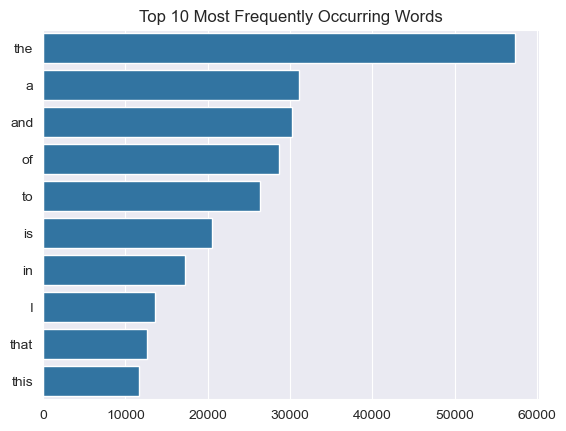

In [33]:
sns.barplot(x = freq, y = words)
plt.title('Top 10 Most Frequently Occurring Words')
plt.show()

## Most Frequently occurring N-Grams
- n-gram is a sequence of n words in a text.
- A bigram means two words in a sequence. "Very good" or "Too great"".
- A trigram means three words in a sequence.
- Seperate text into n-grams using CountVectorizer.

In [34]:
cv = CountVectorizer(ngram_range = (2, 2))
bigrams =cv.fit_transform(review_df['review'])

In [35]:
count_values = bigrams.toarray().sum(axis = 0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

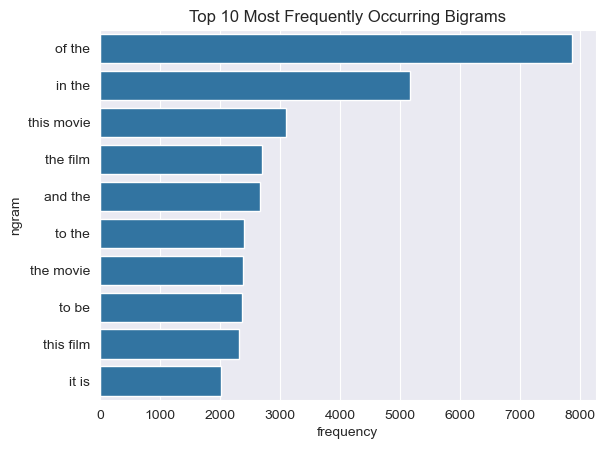

In [36]:
sns.barplot(x = ngram_freq['frequency'][:10], y = ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occurring Bigrams')
plt.show()

In [42]:
cv1 = CountVectorizer(ngram_range = (3, 3))
trigrams = cv1.fit_transform(review_df['review'])
count_values = trigrams.toarray().sum(axis = 0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "trigrams"]

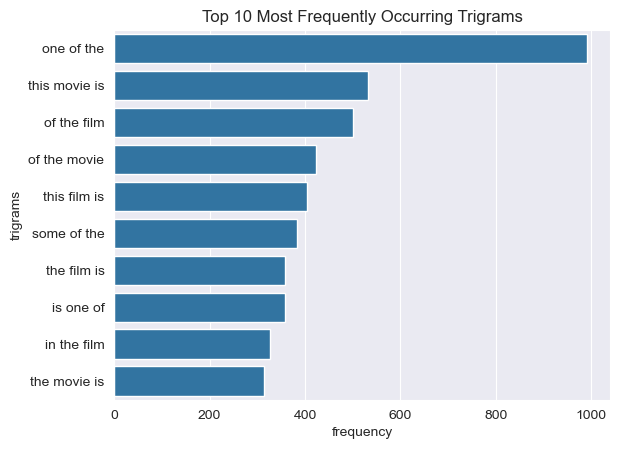

In [45]:
sns.barplot(x = ngram_freq['frequency'][:10], y = ngram_freq['trigrams'][:10])
plt.title('Top 10 Most Frequently Occurring Trigrams')
plt.show()